<a href="https://colab.research.google.com/github/YasinnSoylu/Breast-Cancer-Classification-KERS-PYTORCH/blob/main/KERAS_TUNER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/breast-histopathology-images
!unzip breast-histopathology-images.zip


In [32]:
#import neccessary Libraries and modules
import pandas as pd
import numpy as np
import os
from glob import glob
import random
import matplotlib.pylab as plt

from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import keras.backend as K

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
imagePatches = glob('/content/IDC_regular_ps50_idx5/**/*.png', recursive=True)
for filename in imagePatches[0:10]:
    print(filename)

/content/IDC_regular_ps50_idx5/8984/1/8984_idx5_x2251_y1751_class1.png
/content/IDC_regular_ps50_idx5/8984/1/8984_idx5_x2651_y1151_class1.png
/content/IDC_regular_ps50_idx5/8984/1/8984_idx5_x2801_y1201_class1.png
/content/IDC_regular_ps50_idx5/8984/1/8984_idx5_x2801_y1301_class1.png
/content/IDC_regular_ps50_idx5/8984/1/8984_idx5_x2351_y1251_class1.png
/content/IDC_regular_ps50_idx5/8984/1/8984_idx5_x1901_y1401_class1.png
/content/IDC_regular_ps50_idx5/8984/1/8984_idx5_x1951_y1401_class1.png
/content/IDC_regular_ps50_idx5/8984/1/8984_idx5_x2051_y1801_class1.png
/content/IDC_regular_ps50_idx5/8984/1/8984_idx5_x1901_y1501_class1.png
/content/IDC_regular_ps50_idx5/8984/1/8984_idx5_x2351_y1201_class1.png


In [4]:
# Two arrays holding images by class type

class0 = [] # 0 = no cancer
class1 = [] # 1 = cancer

for filename in imagePatches:
    if filename.endswith("class0.png"):
         class0.append(filename)
    else:
        class1.append(filename)

In [5]:
print("class 0 :",len(class0))
print("class 1 :",len(class1))


class 0 : 198738
class 1 : 78786


In [6]:
sampled_class0 = random.sample(class0, 10000)
sampled_class1 = random.sample(class1, 10000)
#len(sampled_class0)

In [7]:
from matplotlib.image import imread
import cv2

def get_image_arrays(data, label):
    img_arrays = []
    for i in data:
        if i.endswith('.png'):
            img = cv2.imread(i ,cv2.IMREAD_COLOR)
            img_sized = cv2.resize(img, (128, 128), interpolation=cv2.INTER_LINEAR)
            img_arrays.append([img_sized, label])
    return img_arrays

In [8]:
class0_array = get_image_arrays(sampled_class0, 0)
class1_array = get_image_arrays(sampled_class1, 1)

In [9]:
def show_img(files):
    plt.figure(figsize= (10,10))
    ind = np.random.randint(0, len(files), 25)
    i=0
    for loc in ind:
        plt.subplot(5,5,i+1)
        sample = load_img(files[loc], target_size=(150,150))
        sample = img_to_array(sample)
        plt.axis("off")
        plt.imshow(sample.astype("uint8"))
        i+=1

In [10]:
combined_data = np.concatenate((class0_array, class1_array))
random.seed(42)
random.shuffle(combined_data)

In [11]:
X = []
y = []

for features,label in combined_data:
    X.append(features)
    y.append(label)

In [12]:
X = np.array(X).reshape(-1, 128, 128,3)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(15000, 128, 128, 3) (5000, 128, 128, 3) (15000, 2) (5000, 2)


In [48]:
def build_model(hp):  
  model = keras.Sequential([
    keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        input_shape=(128,128,3)
    ),
    keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation='relu'
    ),
    keras.layers.Flatten(),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu'
    ),
    keras.layers.Dense(2, activation='softmax')
  ])
  
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='binary_crossentropy',
              metrics=['accuracy'])
  
  return model

In [49]:
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

In [50]:
tuner_search=RandomSearch(build_model,objective='val_accuracy',max_trials=5,directory='output',project_name="cancer")

In [51]:
tuner_search.search(X_train,y_train,epochs=5,validation_split=0.1)


Trial 5 Complete [00h 02m 23s]
val_accuracy: 0.846666693687439

Best val_accuracy So Far: 0.846666693687439
Total elapsed time: 00h 14m 17s


In [52]:
model=tuner_search.get_best_models(num_models=1)[0]
#summary of best model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 32)      18464     
                                                                 
 flatten (Flatten)           (None, 492032)            0         
                                                                 
 dense (Dense)               (None, 96)                47235168  
                                                                 
 dense_1 (Dense)             (None, 2)                 194       
                                                                 
Total params: 47,255,618
Trainable params: 47,255,618
Non-trainable params: 0
_________________________________________________________________


In [55]:
model.fit(X_train,y_train,
          epochs=10,
         validation_data=(X_test, y_test))

Epoch 1/10
469/469 [==============================] - 22s 46ms/step - loss: 0.4330 - accuracy: 0.8430 - val_loss: 0.4326 - val_accuracy: 0.8426
Epoch 2/10
469/469 [==============================] - 20s 43ms/step - loss: 0.4354 - accuracy: 0.8430 - val_loss: 0.4355 - val_accuracy: 0.8424
Epoch 3/10
469/469 [==============================] - 21s 45ms/step - loss: 0.4451 - accuracy: 0.8430 - val_loss: 0.4357 - val_accuracy: 0.8424
Epoch 4/10
469/469 [==============================] - 21s 45ms/step - loss: 0.4349 - accuracy: 0.8429 - val_loss: 0.4357 - val_accuracy: 0.8424
Epoch 5/10
469/469 [==============================] - 21s 44ms/step - loss: 0.4335 - accuracy: 0.8429 - val_loss: 0.4314 - val_accuracy: 0.8428
Epoch 6/10
469/469 [==============================] - 21s 44ms/step - loss: 0.4351 - accuracy: 0.8429 - val_loss: 0.4357 - val_accuracy: 0.8424
Epoch 7/10
469/469 [==============================] - 22s 46ms/step - loss: 0.4350 - accuracy: 0.8429 - val_loss: 0.4357 - val_accuracy:

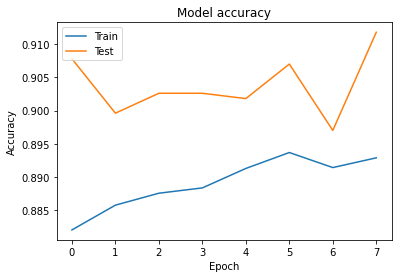

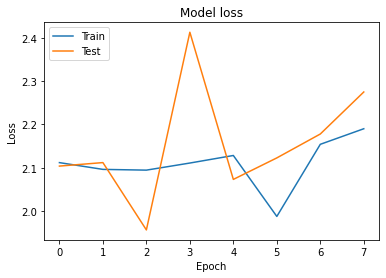

In [56]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot loss values vs epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [58]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)

157/157 [==============================] - 2s 13ms/step - loss: 0.4357 - accuracy: 0.8424


In [59]:
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))


Test: accuracy = 0.842400  ;  loss = 0.435748
